In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import copy
from pylab import grid
import time

In [2]:
eps  = np.finfo(float).eps

In [3]:
###############
#  CSTR model #
###############

# Taken from http://apmonitor.com/do/index.php/Main/NonlinearControl

def cstr(x,t,u):

    # ==  Inputs == #
    Tc  = u   # Temperature of cooling jacket (K)

    # == States == #
    Ca = x[0] # Concentration of A in CSTR (mol/m^3)
    T  = x[1] # Temperature in CSTR (K)

    # == Process parameters == #
    Tf     = 350    # Feed temperature (K)
    q      = 100    # Volumetric Flowrate (m^3/sec)
    Caf    = 1      # Feed Concentration (mol/m^3)
    V      = 100    # Volume of CSTR (m^3)
    rho    = 1000   # Density of A-B Mixture (kg/m^3)
    Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
    mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
    EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0     = 7.2e10 # Pre-exponential factor (1/sec)
    UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    
    # == Equations == #
    rA     = k0*np.exp(-EoverR/T)*Ca # reaction rate
    dCadt  = q/V*(Caf - Ca) - rA     # Calculate concentration derivative
    dTdt   = q/V*(Tf - T) \
              + mdelH/(rho*Cp)*rA \
              + UA/V/rho/Cp*(Tc-T)   # Calculate temperature derivative

    # == Return xdot == #
    xdot    = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

In [4]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(Ca_dat, T_dat, Tc_dat, data_simulation):    
    
    Ca_des = data_simulation['Ca_des']
    T_des = data_simulation['T_des']
    
    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1), 
                           color='r', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,2)
    plt.plot(t, np.median(T_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,3)
    plt.step(t[1:], np.median(Tc_dat,axis=1), 'b--', lw=3)
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    Ca_train = np.array(data_simulation['Ca_train'])
    T_train = np.array(data_simulation['T_train'])
    Tc_train = np.array(data_simulation['Tc_train'])
    Ca_des   = data_simulation['Ca_des']
    T_des    = data_simulation['T_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, Ca_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.title('Training plots')
    plt.ylim([.75, .95])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, T_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.ylim([335, 317])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], Tc_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

In [5]:
data_res = {} 
# Initial conditions for the states
x0             = np.zeros(2)
x0[0]          = 0.87725294608097
x0[1]          = 324.475443431599
data_res['x0'] = x0

In [6]:
# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
Ca = np.zeros(len(t));      Ca[0]  = x0[0]
T  = np.zeros(len(t));      T[0]   = x0[1]    
Tc = np.zeros(len(t)-1);   

data_res['Ca_dat'] = copy.deepcopy(Ca)
data_res['T_dat']  = copy.deepcopy(T) 
data_res['Tc_dat'] = copy.deepcopy(Tc)

In [7]:
# noise level
noise             = 0.1
data_res['noise'] = noise

In [8]:
# control upper and lower bounds
data_res['Tc_ub']  = 305
data_res['Tc_lb']  = 295
Tc_ub              = data_res['Tc_ub']
Tc_lb              = data_res['Tc_lb']

In [9]:
# desired setpoints
n_1                = int(n/2)
n_2                = n - n_1
Ca_des             = [0.8 for i in range(n_1)] + [0.9 for i in range(n_2)]
T_des              = [330 for i in range(n_1)] + [320 for i in range(n_2)]
data_res['Ca_des'] = Ca_des
data_res['T_des']  = T_des

In [10]:
def simulate_CSTR(u_traj, data_simulation, repetitions):
    '''
    u_traj: Trajectory of input values
    data_simulation: Dictionary of simulation data
    repetitions: Number of simulations to perform
    '''
    # loading process operations
    Ca    = copy.deepcopy(data_simulation['Ca_dat']) 
    T     = copy.deepcopy(data_simulation['T_dat']) 
    x0    = copy.deepcopy(data_simulation['x0'])
    t     = copy.deepcopy(data_simulation['t'])     
    noise = data_simulation['noise'] 
    n     = copy.deepcopy(data_simulation['n']) 
         
    # control preparation
    u_traj = np.array(u_traj)
    u_traj = u_traj.reshape(1,n-1, order='C')
    Tc    = u_traj[0,:]

    # creating lists
    Ca_dat    = np.zeros((len(t),repetitions))
    T_dat     = np.zeros((len(t),repetitions))
    Tc_dat    = np.zeros((len(t)-1,repetitions))
    u_mag_dat = np.zeros((len(t)-1,repetitions))  
    u_cha_dat = np.zeros((len(t)-2,repetitions))

    # multiple repetitions
    for rep_i in range(repetitions):
        x   = x0

        # main process simulation loop
        for i in range(len(t)-1):
            ts      = [t[i],t[i+1]]
            # integrate system
            y       = odeint(cstr,x,ts,args=(Tc[i],))
            # adding stochastic behaviour 
            s       = np.random.uniform(low=-1, high=1, size=2)
            Ca[i+1] = y[-1][0] + noise*s[0]*0.1    
            T[i+1]  = y[-1][1] + noise*s[1]*5     
            # state update
            x[0] = Ca[i+1]
            x[1] = T[i+1]

        # data collection
        Ca_dat[:,rep_i]    = copy.deepcopy(Ca)
        T_dat[:,rep_i]     = copy.deepcopy(T)
        Tc_dat[:,rep_i]    = copy.deepcopy(Tc)

    return Ca_dat, T_dat, Tc_dat

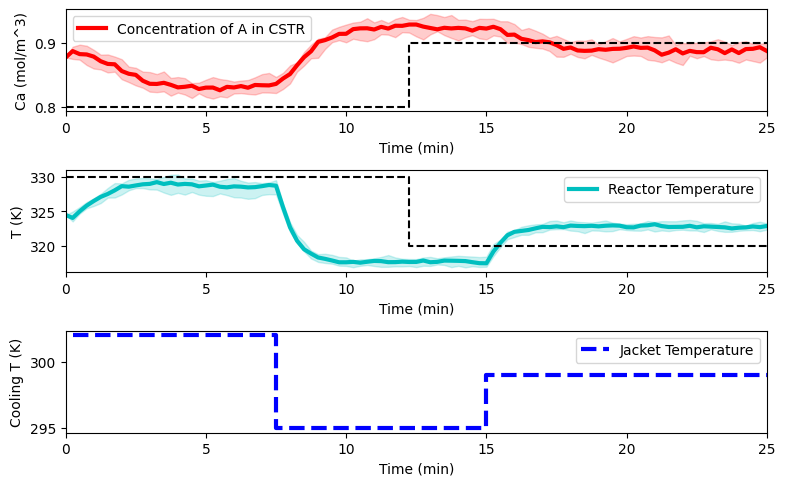

In [11]:
# Step cooling temperature to 295
u_example          = np.zeros((1,n-1))
u_example[0,:30]   = 302.0
u_example[0,30:60] = 295.0
u_example[0,60:]   = 299.0

# Simulation
Ca_dat, T_dat, Tc_dat = simulate_CSTR(u_example, data_res, 10)

# Plot the results
plot_simulation(Ca_dat, T_dat, Tc_dat, data_res)

In [12]:
##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(7, order='C')

    # K gains
    KpCa = Ks[0]; KiCa = Ks[1]; KdCa = Ks[2]
    KpT  = Ks[3]; KiT  = Ks[4]; KdT  = Ks[5]; 
    Kb   = Ks[6]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpCa*e[0] + KiCa*sum(e_history[:,0]) + KdCa*(e[0]-e_history[-1,0])
    u += KpT *e[1] + KiT *sum(e_history[:,1]) + KdT *(e[1]-e_history[-1,1])
    u += Kb
    u  = min(max(u,data_res['Tc_lb']),data_res['Tc_ub'])

    return u

In [13]:
def J_ControlCSTR(Ks, data_res=data_res, collect_training_data=True, traj=False):
    
    # load data
    Ca    = copy.deepcopy(data_res['Ca_dat'])
    T     = copy.deepcopy(data_res['T_dat'])
    Tc    = copy.deepcopy(data_res['Tc_dat'])
    t     = copy.deepcopy(data_res['t']) 
    x0    = copy.deepcopy(data_res['x0'])    
    noise = data_res['noise']
    
    # setpoints      
    Ca_des = data_res['Ca_des']; T_des = data_res['T_des']
    
    # upper and lower bounds
    Tc_ub  = data_res['Tc_ub'];  Tc_lb  = data_res['Tc_lb']

    # initiate
    x         = x0
    e_history = []

    # Simulate CSTR with PID controller
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([Ca_des[i],T_des[i]])
        # compute control
        if i == 0:
            Tc[i] = PID(Ks, x, x_sp, np.array([[0,0]]))
        else:
            Tc[i] = PID(Ks, x, x_sp, np.array(e_history))
        # simulate system
        y         = odeint(cstr,x,ts,args=(Tc[i],))
        # add process disturbance
        s       = np.random.uniform(low=-1, high=1, size=2)
        Ca[i+1] = y[-1][0] + noise*s[0]*0.1    
        T[i+1]  = y[-1][1] + noise*s[1]*5     
        # state update
        x[0] = Ca[i+1]
        x[1] = T[i+1]
        # compute tracking error
        e_history.append((x_sp-x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15
    # penalize magnitud of control action
    u_mag = np.abs(Tc[:]-Tc_lb)/10
    u_mag = u_mag/10
    # penalize change in control action
    u_cha = np.abs(Tc[1:]-Tc[0:-1])/10
    u_cha = u_cha/10

    # collect data for plots
    if collect_training_data:
        data_res['Ca_train'].append(Ca)
        data_res['T_train'].append(T)
        data_res['Tc_train'].append(Tc)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)
        data_res['Ks'].append(Ks)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if traj:
      return Ca, T, Tc
    else:
      return error + u_mag + u_cha

In [14]:
#########################
# --- Random search --- #
#########################

# (f, N_x: int, bounds: array[array[float]], N: int = 100) -> array(N_X), float 
def Random_search(f, n_p, bounds_rs, iter_rs):
    '''
    This function is a naive optimization routine that randomly samples the 
    allowed space and returns the best value.

    This is used to find a good starting point
    '''

    # arrays to store sampled points
    localx   = np.zeros((n_p,iter_rs))  # points sampled
    localval = np.zeros((iter_rs))        # function values sampled
    # bounds
    bounds_range = bounds_rs[:,1] - bounds_rs[:,0]
    bounds_bias  = bounds_rs[:,0]

    for sample_i in range(iter_rs):
        x_trial = np.random.uniform(0, 1, n_p)*bounds_range + bounds_bias # sampling
        localx[:,sample_i] = x_trial
        localval[sample_i] = f(x_trial) # f
    # choosing the best
    minindex = np.argmin(localval)
    f_b      = localval[minindex]
    x_b      = localx[:,minindex]

    return f_b,x_b

In [15]:
if 'google.colab' in str(get_ipython()):
    !pip install Py-BOBYQA
import pybobyqa

In [16]:
def opt_PyBOBYQA(f, x_dim, bounds, iter_tot):
    '''
    More info:
    https://numericalalgorithmsgroup.github.io/pybobyqa/build/html/userguide.html#a-simple-example
    '''

    # iterations to find good starting point
    n_rs = 3

    # evaluate first point
    f_best, x_best = Random_search(f, x_dim, bounds, n_rs)
    iter_          = iter_tot - n_rs

    # restructure bounds
    a = bounds[:,0]; b = bounds[:,1]
    pybobyqa_bounds    = (a,b)
    other_outputs      = {}

    soln = pybobyqa.solve(f, x_best, seek_global_minimum=True, 
                          objfun_has_noise=True,
                          user_params = {'restarts.use_restarts':True,
                                         'logging.save_diagnostic_info': True,
                                         'logging.save_xk': True}, 
                          maxfun=iter_, 
                          bounds=pybobyqa_bounds, 
                          rhobeg=0.1)
    
    other_outputs['soln']  = soln
    other_outputs['x_all'] = np.array(soln.diagnostic_info['xk'].tolist())

    return soln.x, f(soln.x), other_outputs

this optimization took  2.0488274097442627  (s)


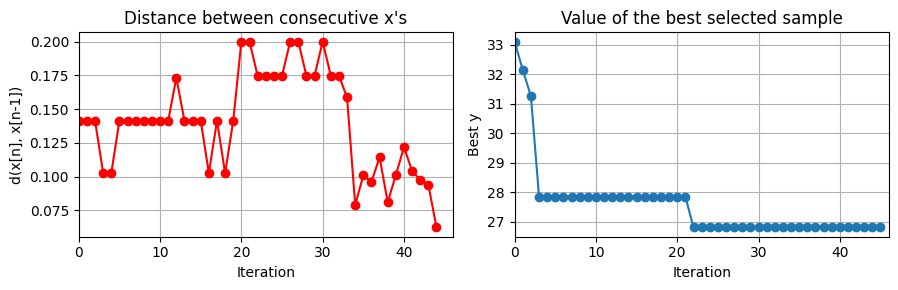

In [17]:
iter_tot =  50

# bounds
boundsK = np.array([[0.,10./0.2]]*3 + [[0.,10./15]]*3 + [[Tc_lb-20,Tc_lb+20]])

# plot training data
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []
data_res['Ks']          = []

start_time = time.time()
Kbobyqa, f_opt, other_outputs = opt_PyBOBYQA(J_ControlCSTR, 7, boundsK, iter_tot)
end_time   = time.time()

print('this optimization took ',end_time - start_time,' (s)')

plot_convergence(np.array(data_res['Ks'])[5:], None, J_ControlCSTR)


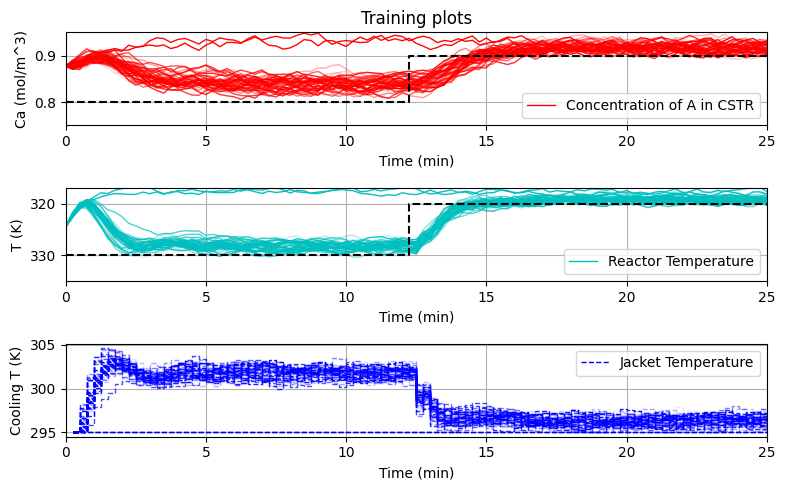

In [18]:
plot_training(data_res,iter_tot)

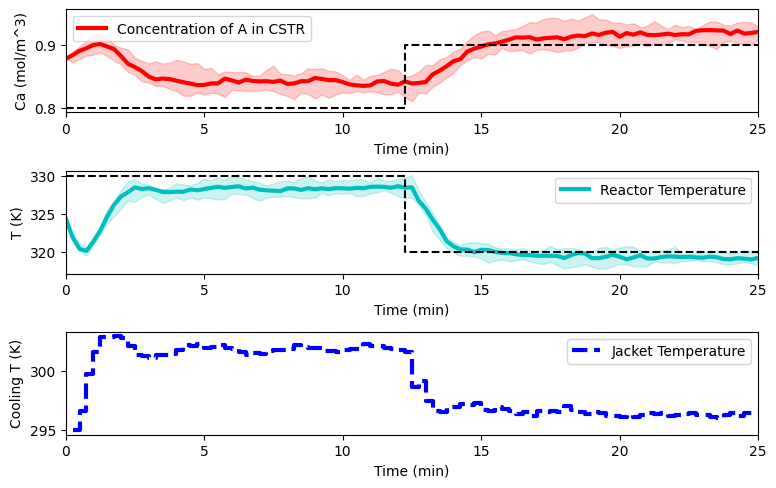

In [19]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_ControlCSTR(Kbobyqa, 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

In [20]:
if 'google.colab' in str(get_ipython()):
    !pip install gpyopt

import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [21]:
def opt_GPyOpt(f, x_dim, bounds, iter_tot):
    '''
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    '''

    bounds_GPyOpt = [{'name':'var_'+str(i+1),
                    'type': 'continuous',
                    'domain': (bounds[i,0],bounds[i,1])}
                    for i in range(len(bounds))]

    myBopt = GPyOpt.methods.BayesianOptimization(f, domain=bounds_GPyOpt)
    myBopt.run_optimization(max_iter = iter_tot)

    return myBopt.x_opt, myBopt.fx_opt, myBopt

this optimization took  35.1505012512207  (s)


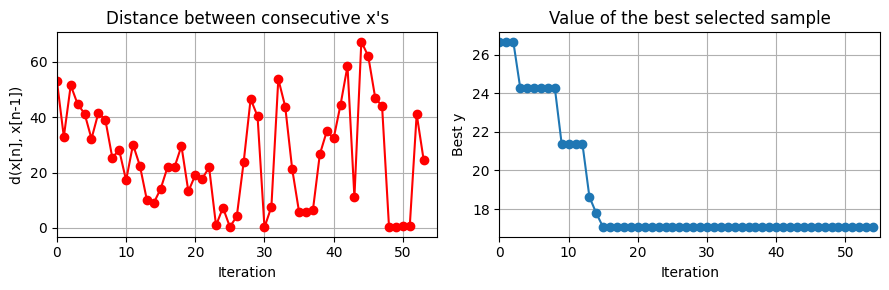

In [22]:
iter_tot =  50

# bounds
boundsK = np.array([[0.,10./0.2]]*3 + [[0.,10./15]]*3 + [[Tc_lb-20,Tc_lb+20]])
# plot training data
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []
data_res['Ks']          = []

start_time = time.time()
KBOpt, f_opt, other_outputs = opt_GPyOpt(J_ControlCSTR, 7, boundsK, iter_tot)
end_time   = time.time()

print('this optimization took ',end_time - start_time,' (s)')

evals = np.array(data_res['Ks']).shape[0]
plot_convergence(np.array(data_res['Ks']).reshape(evals,7), None, J_ControlCSTR)

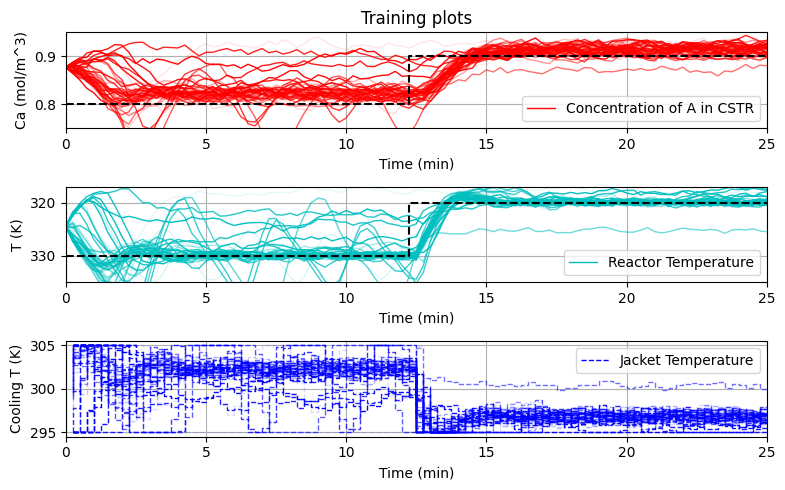

In [23]:
plot_training(data_res, iter_tot)

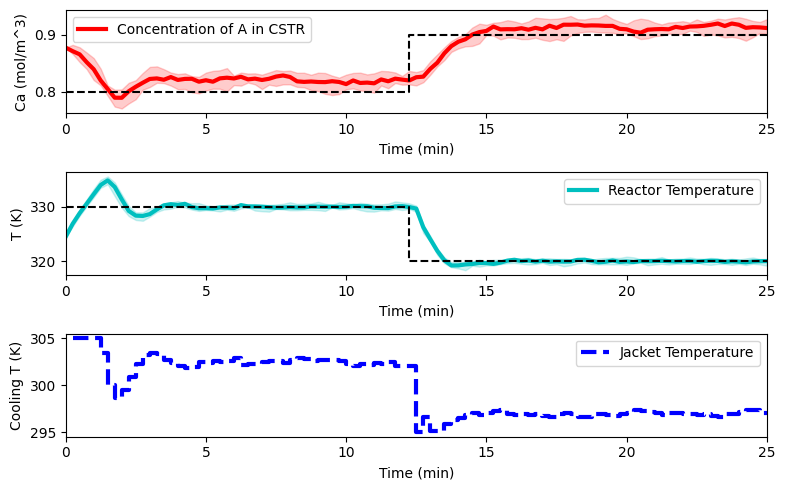

In [24]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_ControlCSTR(KBOpt, 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

In [25]:
if 'google.colab' in str(get_ipython()):
    !pip install gurobipy
    !pip install git+https://github.com/cog-imperial/entmoot

from entmoot.optimizer.optimizer import Optimizer

In [26]:
def opt_ENTMOOT(f, x_dim, bounds, iter_tot):
    '''
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    '''
    
    opt = Optimizer(bounds,
                    base_estimator="ENTING",
                    n_initial_points=int(iter_tot*.2),
                    initial_point_generator="random",
                    acq_func="LCB",
                    acq_optimizer="sampling",
                    random_state=100,
                    model_queue_size=None,
                    base_estimator_kwargs={
                        "lgbm_params": {"min_child_samples": 1}
                    },
                    verbose=False,
                    )

    # run optimizer for 20 iterations
    res = opt.run(f, n_iter=iter_tot)

    return res.x, res.fun, res

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 5/50 [00:00<00:01, 40.02it/s]

 20%|████████████████▍                                                                 | 10/50 [00:00<00:01, 39.28it/s]

 28%|██████████████████████▉                                                           | 14/50 [00:02<00:10,  3.57it/s]

 34%|███████████████████████████▉                                                      | 17/50 [00:04<00:13,  2.52it/s]

 38%|███████████████████████████████▏                                                  | 19/50 [00:06<00:15,  2.06it/s]

 40%|████████████████████████████████▊                                                 | 20/50 [00:07<00:15,  1.95it/s]

 42%|██████████████████████████████████▍                                               | 21/50 [00:07<00:15,  1.83it/s]

 44%|████████████████████████████████████                                              | 22/50 [00:08<00:16,  1.74it/s]

 46%|█████████████████████████████████████▋                                            | 23/50 [00:09<00:16,  1.60it/s]

 48%|███████████████████████████████████████▎                                          | 24/50 [00:10<00:16,  1.56it/s]

 50%|█████████████████████████████████████████                                         | 25/50 [00:10<00:17,  1.47it/s]

 52%|██████████████████████████████████████████▋                                       | 26/50 [00:11<00:17,  1.34it/s]

 54%|████████████████████████████████████████████▎                                     | 27/50 [00:12<00:17,  1.35it/s]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:13<00:16,  1.35it/s]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:14<00:15,  1.34it/s]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:14<00:14,  1.35it/s]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:15<00:14,  1.35it/s]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:16<00:13,  1.36it/s]

 66%|██████████████████████████████████████████████████████                            | 33/50 [00:17<00:12,  1.33it/s]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:17<00:11,  1.33it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:18<00:11,  1.33it/s]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:19<00:10,  1.33it/s]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:20<00:09,  1.33it/s]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:20<00:09,  1.33it/s]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:21<00:08,  1.33it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:22<00:07,  1.32it/s]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:23<00:06,  1.30it/s]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:23<00:06,  1.26it/s]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:24<00:05,  1.26it/s]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:25<00:04,  1.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:26<00:03,  1.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:27<00:03,  1.22it/s]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:28<00:02,  1.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:28<00:01,  1.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:29<00:00,  1.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]

this optimization took  30.688970804214478  (s)


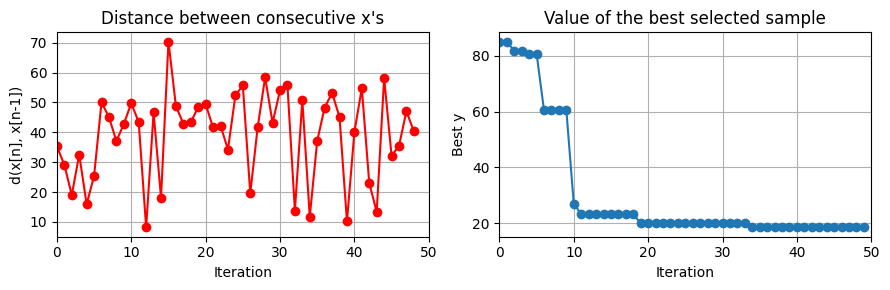

In [27]:
iter_tot =  50

# bounds
boundsK = np.array([[0.,10./0.2]]*3 + [[0.,10./15]]*3 + [[Tc_lb-20,Tc_lb+20]])
# plot training data
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []
data_res['Ks']          = []

start_time = time.time()
KentMoot, f_opt, other_outputs = opt_ENTMOOT(J_ControlCSTR, 7, boundsK, iter_tot)
end_time   = time.time()

print('this optimization took ',end_time - start_time,' (s)')

#evals = np.array(data_res['Ks']).shape[0]
plot_convergence(np.array(data_res['Ks']), None, J_ControlCSTR)

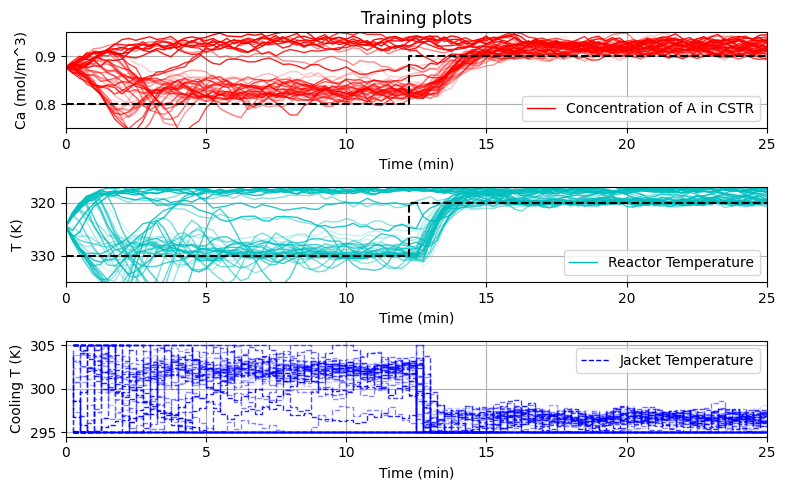

In [28]:
plot_training(data_res,iter_tot)

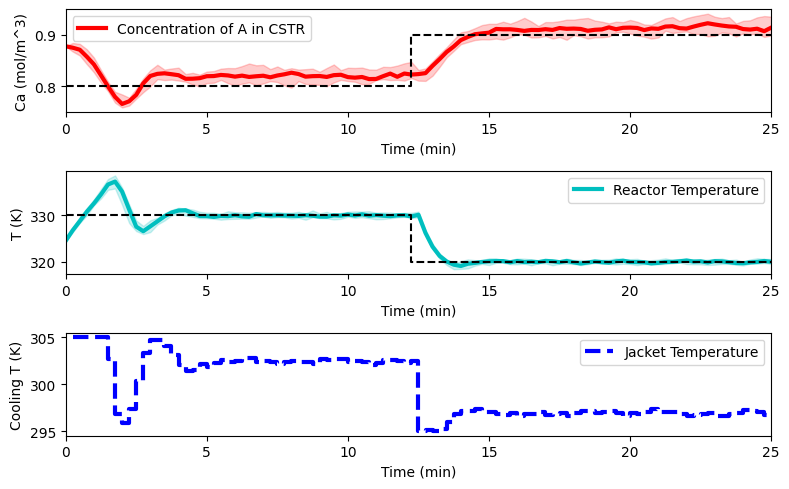

In [29]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_ControlCSTR(KentMoot, 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)